In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from io import open
import unicodedata
import string
import re
import random
import zipfile
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Prepare Data

In [2]:
with zipfile.ZipFile('rus-eng.zip') as myzip:
    myzip.extractall()

In [3]:
with open('rus.txt', encoding='utf-8') as file:
    lines = file.readlines()
    print(*random.sample(lines, 10))

I shouldn't drink.	Не надо бы мне пить.	CC-BY 2.0 (France) Attribution: tatoeba.org #2247411 (CK) & #5616837 (marafon)
 Tom was faster than me.	Том был быстрее меня.	CC-BY 2.0 (France) Attribution: tatoeba.org #6273206 (CK) & #6369862 (marafon)
 Don't get your new pants dirty.	Не испачкай новые брюки.	CC-BY 2.0 (France) Attribution: tatoeba.org #8592632 (CK) & #8592641 (marafon)
 I want you to get rid of all this.	Я хочу, чтобы ты от всего этого избавился.	CC-BY 2.0 (France) Attribution: tatoeba.org #8027086 (CK) & #8934019 (marafon)
 I thought they were speaking French.	Я думал, они говорят по-французски.	CC-BY 2.0 (France) Attribution: tatoeba.org #8523723 (CK) & #9162217 (marafon)
 Do you know which deity this temple is dedicated to?	Вы знаете, какому божеству посвящён этот храм?	CC-BY 2.0 (France) Attribution: tatoeba.org #58959 (CM) & #1796472 (Balamax)
 Are you still waiting for Tom?	Вы до сих пор ждёте Тома?	CC-BY 2.0 (France) Attribution: tatoeba.org #6348426 (CK) & #6682221 (m

In [4]:
with open('eng-rus.txt', 'w', encoding='utf-8') as file:
    for line in lines:
        stripped = line.split('\t')
        file.write(stripped[0] + '\t' + stripped[1] + '\n')

In [5]:
with open('eng-rus.txt', encoding='utf-8') as file:
    lines = file.readlines()
    print(*random.sample(lines, 10))

I was at the gym.	Я была в спортзале.
 I'm waiting for you to apologize.	Я жду, чтобы ты извинилась.
 I'm not prepared for this.	Я не готов к этому.
 We could've done this without your help.	Мы могли бы сделать это и без вашей помощи.
 Do I know you?	Я тебя знаю?
 Tom has been here for a few days.	Том здесь уже несколько дней.
 You ought to see a doctor.	Тебе лучше показаться врачу.
 Where are the rest of the boys?	Где остальные ребята?
 I don't even know if that's possible.	Я даже не знаю, возможно ли это.
 Does that have anything to do with what we're talking about?	Это имеет какое-то отношение к тому, о чём мы сейчас говорим?



In [6]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z-А-аЯ-я.!?]+", r" ", s)
    return s

In [8]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [9]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 479223 sentence pairs
Trimmed to 27844 sentence pairs
Counting words...
Counted words:
rus 10125
eng 4320
['мы с вами в однои лодке .', 'i m in the same boat as you .']


# Define train function

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [12]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    keys = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden, key = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        keys[ei] = key[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, keys)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, keys)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [13]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [15]:
# import matplotlib.pyplot as plt
# plt.switch_backend('agg')
# import matplotlib.ticker as ticker



def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [67]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        keys = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, key = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            keys[ei] += key[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs, keys)
            decoder_attentions[di] = decoder_attention.squeeze().data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [74]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [68]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick

    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, encoder, decoder):
    output_words, attentions = evaluate(
        encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

# Исходная модель

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden, embedded

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, keys):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

1m 50s (- 53m 35s) (5000 3%) 3.0817
3m 29s (- 48m 57s) (10000 6%) 2.5972
5m 9s (- 46m 24s) (15000 10%) 2.3367
6m 48s (- 44m 12s) (20000 13%) 2.1669
8m 27s (- 42m 15s) (25000 16%) 1.9933
10m 5s (- 40m 21s) (30000 20%) 1.8972
11m 46s (- 38m 39s) (35000 23%) 1.7568
13m 25s (- 36m 53s) (40000 26%) 1.6865
15m 4s (- 35m 11s) (45000 30%) 1.5749
16m 44s (- 33m 28s) (50000 33%) 1.5222
18m 23s (- 31m 45s) (55000 36%) 1.4294
20m 4s (- 30m 6s) (60000 40%) 1.3607
21m 44s (- 28m 26s) (65000 43%) 1.3419
23m 23s (- 26m 43s) (70000 46%) 1.2856
25m 3s (- 25m 3s) (75000 50%) 1.2489
26m 43s (- 23m 22s) (80000 53%) 1.2073
28m 24s (- 21m 43s) (85000 56%) 1.1856
30m 3s (- 20m 2s) (90000 60%) 1.1409
31m 45s (- 18m 23s) (95000 63%) 1.1294
33m 26s (- 16m 43s) (100000 66%) 1.0948
35m 6s (- 15m 2s) (105000 70%) 1.0839
36m 46s (- 13m 22s) (110000 73%) 1.0241
38m 28s (- 11m 42s) (115000 76%) 1.0103
40m 8s (- 10m 2s) (120000 80%) 0.9810
41m 50s (- 8m 22s) (125000 83%) 0.9690
43m 31s (- 6m 41s) (130000 86%) 0.9681
45

<Figure size 640x480 with 0 Axes>

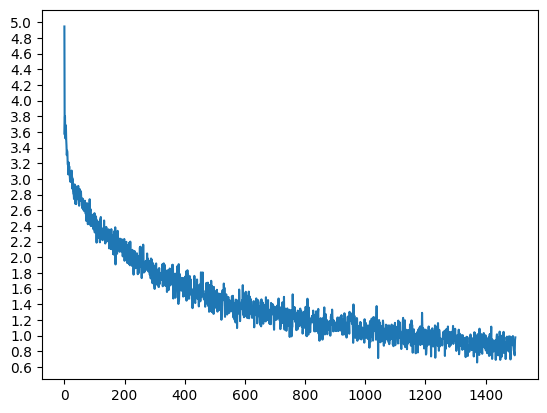

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 150000, print_every=5000)

In [22]:
evaluateRandomly(encoder1, attn_decoder1)

> мы ждем что вы нам поможете .
= we re waiting for you to help us .
< we re waiting for you to us you . <EOS>

> у меня часто бывают неприятности .
= i m often in trouble .
< i m often in trouble trouble . <EOS>

> слушаю вас .
= i m listening to you .
< i m listening to you . <EOS>

> я возвращаюсь чтобы поспать .
= i m going back to sleep .
< i m going back to back back . <EOS>

> я голодна !
= i m hungry !
< i m hungry ! <EOS>

> они ждут снаружи .
= they re waiting outside .
< they re waiting for . <EOS>

> он прекрасныи неирохирург .
= he s an excellent brain surgeon .
< he s a great japanese . . <EOS>

> я рад что ты придешь .
= i m glad that you ll come .
< i m glad you you you you . . .

> я всегда очень занят .
= i m always very busy .
< i m always all busy the . . <EOS>

> очень рада снова вас видеть .
= i m happy to see you again .
< i m happy to see you again . <EOS>



input = я уверен что у него получится .
output = i m sure that ll ll succeed . <EOS>


C:\Users\anana\AppData\Local\Temp\ipykernel_440\3633848714.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\anana\AppData\Local\Temp\ipykernel_440\3633848714.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


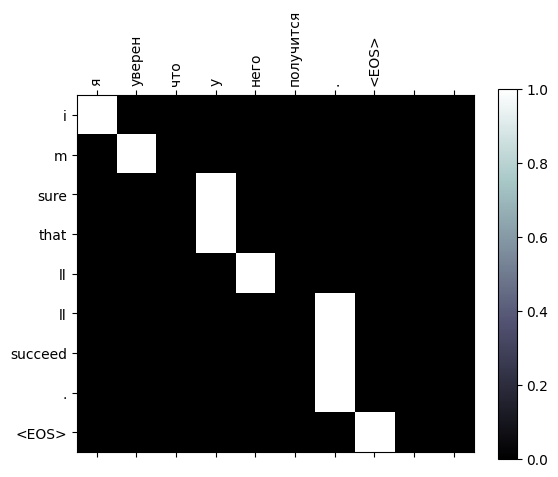

input = я начинаю терять надежду .
output = i m starting to lose tom . <EOS>


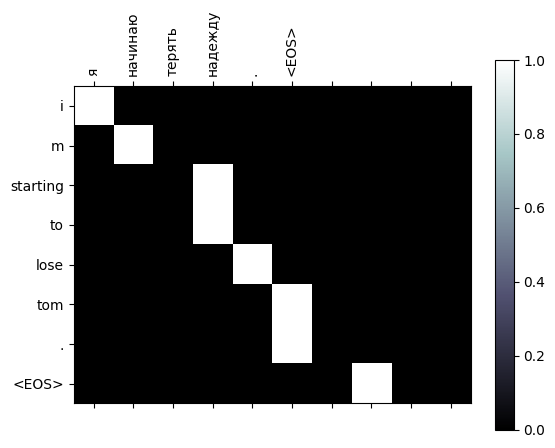

input = тебе столько же лет сколько и мне .
output = you re the only age . . . <EOS>


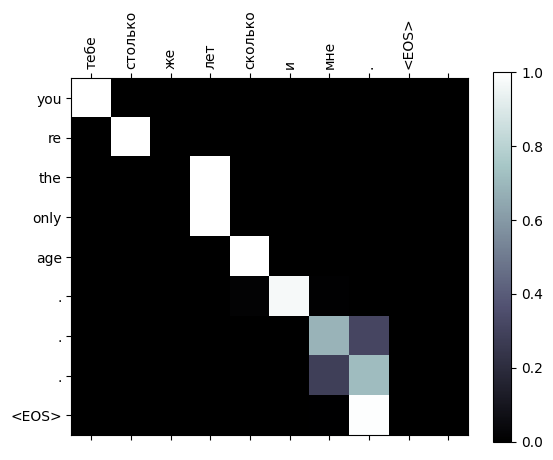

input = я отчитываю своих студентов а не ваших .
output = i m asking my money but not . <EOS>


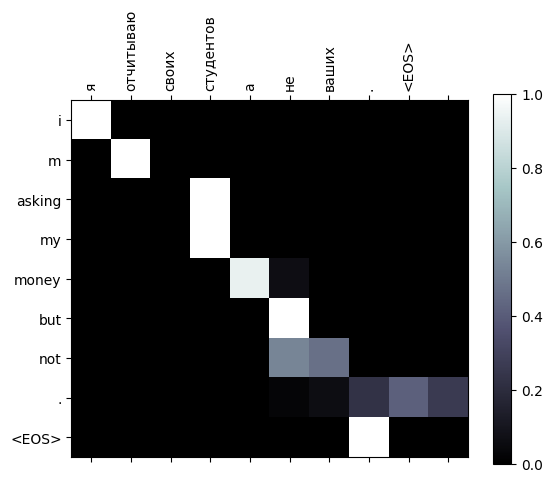

In [23]:
evaluateAndShowAttention("я уверен что у него получится .", encoder1, attn_decoder1)

evaluateAndShowAttention("я начинаю терять надежду .", encoder1, attn_decoder1)

evaluateAndShowAttention("тебе столько же лет сколько и мне .", encoder1, attn_decoder1)

evaluateAndShowAttention("я отчитываю своих студентов а не ваших .", encoder1, attn_decoder1)

Полученный перевод в целом является лучше чем простой seq2seq, проблем с переводом последних слов стало меньше, но по какой-то причине модель очень полюбила задваивать и затраивать точки

# Dot product attention

In [24]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        key = embedded
        output, hidden = self.gru(key, hidden)
        return output, hidden, key

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, keys):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            torch.matmul(embedded, keys.T)/(self.hidden_size**0.5), dim=2)
        attn_applied = torch.bmm(attn_weights,
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

1m 50s (- 53m 26s) (5000 3%) 3.1249
3m 29s (- 48m 53s) (10000 6%) 2.6235
5m 8s (- 46m 20s) (15000 10%) 2.3505
6m 48s (- 44m 18s) (20000 13%) 2.1477
8m 29s (- 42m 27s) (25000 16%) 1.9691
10m 9s (- 40m 36s) (30000 20%) 1.8421
11m 49s (- 38m 51s) (35000 23%) 1.7546
13m 30s (- 37m 7s) (40000 26%) 1.6455
15m 9s (- 35m 21s) (45000 30%) 1.5737
16m 48s (- 33m 37s) (50000 33%) 1.4718
18m 27s (- 31m 53s) (55000 36%) 1.4039
20m 7s (- 30m 11s) (60000 40%) 1.3840
21m 48s (- 28m 31s) (65000 43%) 1.2783
23m 29s (- 26m 51s) (70000 46%) 1.2508
25m 10s (- 25m 10s) (75000 50%) 1.1877
26m 50s (- 23m 29s) (80000 53%) 1.1465
28m 31s (- 21m 48s) (85000 56%) 1.1113
30m 11s (- 20m 7s) (90000 60%) 1.0492
31m 52s (- 18m 27s) (95000 63%) 1.0308
33m 32s (- 16m 46s) (100000 66%) 0.9865
35m 12s (- 15m 5s) (105000 70%) 0.9769
36m 53s (- 13m 24s) (110000 73%) 0.9473
38m 33s (- 11m 44s) (115000 76%) 0.8984
40m 13s (- 10m 3s) (120000 80%) 0.8753
41m 54s (- 8m 22s) (125000 83%) 0.8295
43m 36s (- 6m 42s) (130000 86%) 0.84

<Figure size 640x480 with 0 Axes>

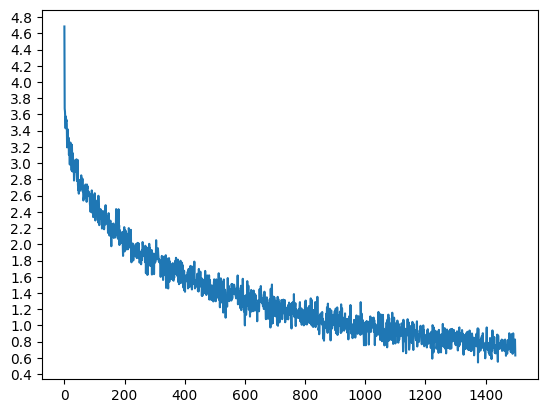

In [26]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder2, attn_decoder2, 150000, print_every=5000)

In [27]:
evaluateRandomly(encoder2, attn_decoder2)

> вы очень смелая .
= you re very brave .
< you are very brave . <EOS>

> мы просто разговариваем .
= we re just talking .
< we re just talking . <EOS>

> мы должны придерживаться графика .
= we re on a schedule .
< we re on the best . <EOS>

> я боюсь за детеи .
= i m scared for my kids .
< i m afraid for the kids . <EOS>

> я через три дня уезжаю .
= i m leaving in three days .
< i m leaving in three days . <EOS>

> я рада что ты решила приити .
= i m glad you decided to come .
< i m glad you decided to come . <EOS>

> я не твоя рабыня .
= i m not your slave .
< i m not your slave . <EOS>

> ты очень хорошии ударник .
= you re a very good drummer .
< you re a very good drummer . <EOS>

> они не преступники .
= they re not criminals .
< they aren t criminals . <EOS>

> я женат и у меня двое детеи .
= i am married and have two children .
< i am married and two two children . <EOS>



input = я уверен что у него получится .
output = i am sure that he will succeed . <EOS>


C:\Users\anana\AppData\Local\Temp\ipykernel_440\3633848714.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\anana\AppData\Local\Temp\ipykernel_440\3633848714.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


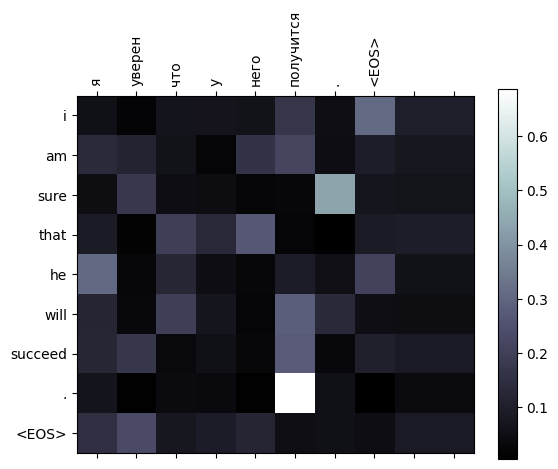

input = я начинаю терять надежду .
output = i m beginning to get to . . <EOS>


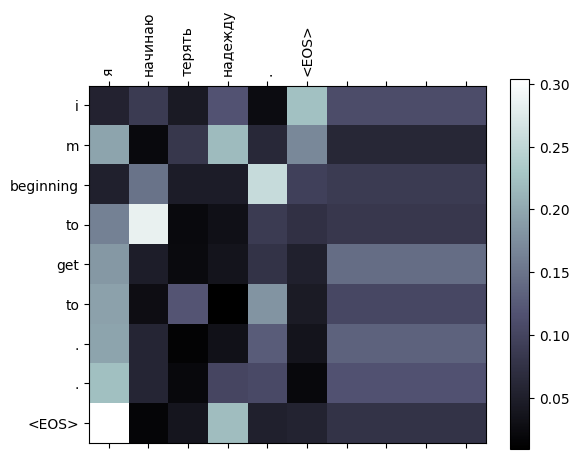

input = тебе столько же лет сколько и мне .
output = you re the same age . <EOS>


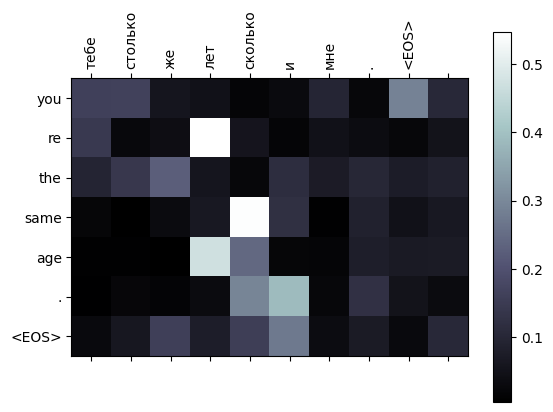

input = я отчитываю своих студентов а не ваших .
output = i m not i not not . . <EOS>


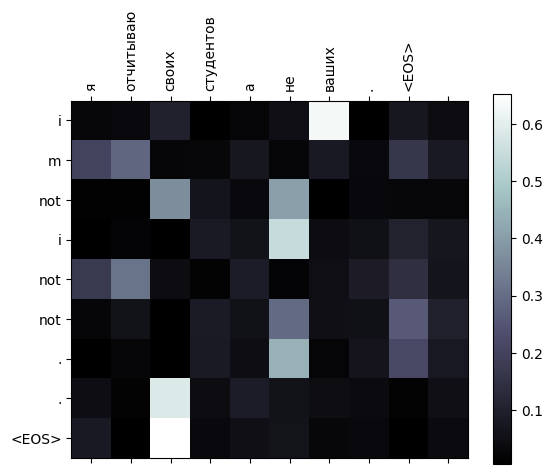

In [28]:
evaluateAndShowAttention("я уверен что у него получится .", encoder2, attn_decoder2)

evaluateAndShowAttention("я начинаю терять надежду .", encoder2, attn_decoder2)

evaluateAndShowAttention("тебе столько же лет сколько и мне .", encoder2, attn_decoder2)

evaluateAndShowAttention("я отчитываю своих студентов а не ваших .", encoder2, attn_decoder2)

Перевод с вниманием по скалярному произведению получился лучше исходного варианта, соответвенно лучше и варианта без внимания. Проблема удвоения точек снизилась, но, к сожалению, не исчезла. Карты внимания сложно интерпретировать, похоже, что можель смотрит либо на всё понемногу, либо сильно на контекст случайного слова.

# MLP attention

In [69]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        key = embedded
        output, hidden = self.gru(key, hidden)
        return output, hidden, key

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [70]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Sequential(nn.Linear(self.hidden_size * 2, 1), nn.Tanh())
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, keys):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_input = torch.zeros(len(keys), self.hidden_size*2, device=device)
        for i in range(len(attn_input)):
            attn_input[i] += torch.cat(
                (embedded[0, 0], keys[i]), dim=0)
        
        attn_weights = F.softmax(
           self.attn(attn_input), dim=0)

        attn_applied = torch.bmm(attn_weights.view(1, 1, -1),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

5m 35s (- 162m 15s) (5000 3%) 3.1026
10m 41s (- 149m 39s) (10000 6%) 2.6372
15m 32s (- 139m 55s) (15000 10%) 2.3558
20m 24s (- 132m 37s) (20000 13%) 2.1683
25m 13s (- 126m 7s) (25000 16%) 1.9881
30m 8s (- 120m 34s) (30000 20%) 1.8991
35m 5s (- 115m 17s) (35000 23%) 1.7312
40m 0s (- 110m 1s) (40000 26%) 1.6637
45m 0s (- 105m 0s) (45000 30%) 1.5643
50m 3s (- 100m 7s) (50000 33%) 1.4732
54m 58s (- 94m 57s) (55000 36%) 1.4271
59m 51s (- 89m 46s) (60000 40%) 1.3721
64m 47s (- 84m 43s) (65000 43%) 1.3138
69m 46s (- 79m 44s) (70000 46%) 1.2415
74m 43s (- 74m 43s) (75000 50%) 1.2046
79m 41s (- 69m 44s) (80000 53%) 1.1490
84m 41s (- 64m 45s) (85000 56%) 1.1081
89m 50s (- 59m 53s) (90000 60%) 1.0998
94m 48s (- 54m 53s) (95000 63%) 1.0318
99m 48s (- 49m 54s) (100000 66%) 1.0174
104m 49s (- 44m 55s) (105000 70%) 0.9824
109m 50s (- 39m 56s) (110000 73%) 0.9255
114m 49s (- 34m 56s) (115000 76%) 0.9257
119m 51s (- 29m 57s) (120000 80%) 0.9096
124m 57s (- 24m 59s) (125000 83%) 0.8547
129m 32s (- 19m 5

<Figure size 640x480 with 0 Axes>

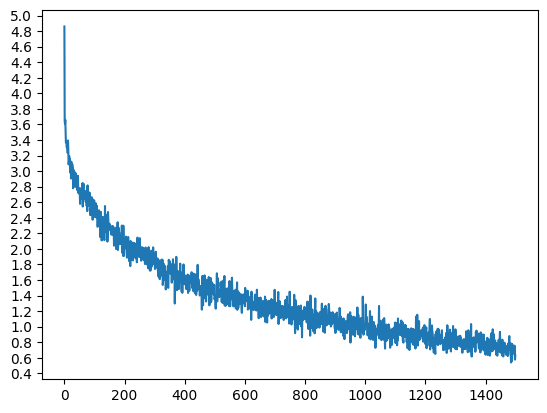

In [71]:
hidden_size = 256
encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder3 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder3, attn_decoder3, 150000, print_every=5000)

In [75]:
evaluateRandomly(encoder3, attn_decoder3)

> мы семья .
= we re a family .
< we re family . <EOS>

> я собираюсь изучать французскии .
= i m going to study french .
< i m going to study french . <EOS>

> у меня никотиновая зависимость .
= i m addicted to nicotine .
< i m pretty a . . <EOS>

> мне скоро тридцать .
= i m about to turn thirty .
< i m thirty by soon . <EOS>

> ты безнадежна .
= you re desperate .
< you re hopeless . <EOS>

> я все еще жду когда это произоидет .
= i m still waiting for it to happen .
< i m still waiting for it . <EOS>

> вы единственныи кого я тут знаю .
= you re the only person i know here .
< you re the only person i know here . <EOS>

> я рад что ты в порядке .
= i m glad you re all right .
< i m glad you re all right . <EOS>

> я слепои а не глухои .
= i m blind not deaf .
< i m blind at the . <EOS>

> я просматриваю его отчет .
= i m looking over his report .
< i m going to read in the . . <EOS>



input = я уверен что у него получится .
output = i am sure that he will succeed . <EOS>


C:\Users\anana\AppData\Local\Temp\ipykernel_440\3633848714.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\anana\AppData\Local\Temp\ipykernel_440\3633848714.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


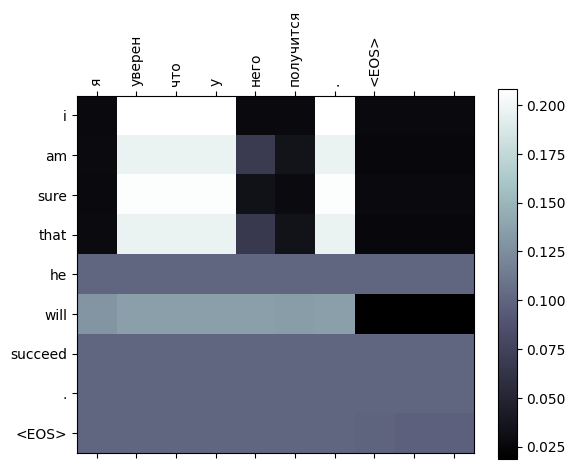

input = я начинаю терять надежду .
output = i m beginning to lose hope . <EOS>


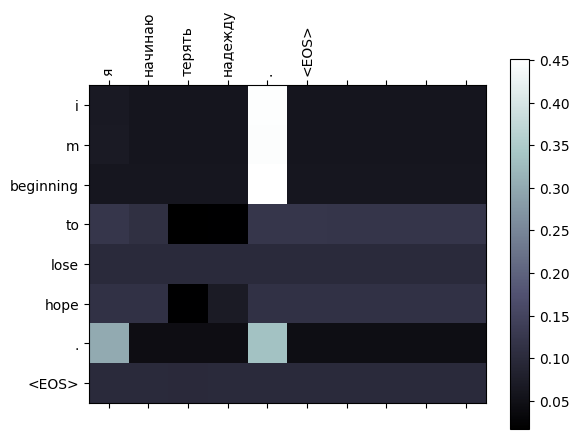

input = тебе столько же лет сколько и мне .
output = you re the same age as me . <EOS>


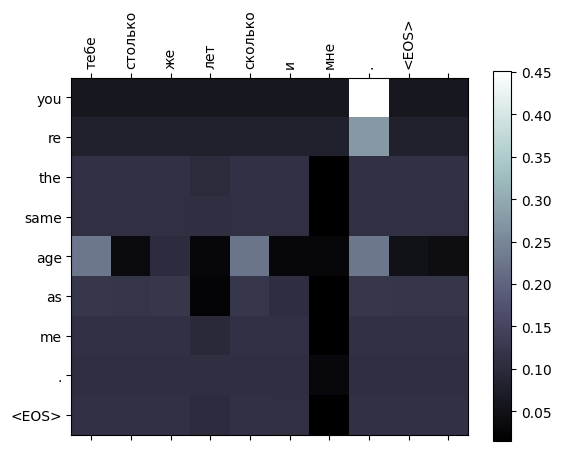

input = я отчитываю своих студентов а не ваших .
output = i m not one of your dog . <EOS>


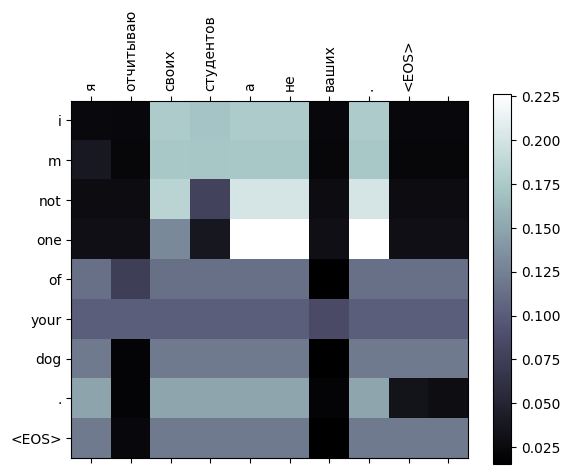

In [76]:
evaluateAndShowAttention("я уверен что у него получится .", encoder3, attn_decoder3)

evaluateAndShowAttention("я начинаю терять надежду .", encoder3, attn_decoder3)

evaluateAndShowAttention("тебе столько же лет сколько и мне .", encoder3, attn_decoder3)

evaluateAndShowAttention("я отчитываю своих студентов а не ваших .", encoder3, attn_decoder3)

MLP attention обучилась почти так же хорошо как dot product. Хотя иногда можно наблюдать неплохой перевод, карты внимания выглядят странно. По сравнению с обычной seq2seq проблем с концом предложения также стало меньше